In [126]:
# Mount your Google Drive to this notebook
# The purpose is to allow your code to access to your files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [127]:
# Change the directory to your working directory
import os
os.chdir('/content/drive/MyDrive/')

In [128]:
# Import library modules
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
# PIL is the Python Imaging Library
from PIL import Image  
# The following is a substitute for cv2.imshow, which Colab does not allow
from google.colab.patches import cv2_imshow

print('Python version:', sys.version)
print('OpenCV version:', cv2.__version__)
print('NumPy version: ', np.__version__)

Python version: 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
OpenCV version: 4.1.2
NumPy version:  1.19.5


Number of detected keypoints = 161


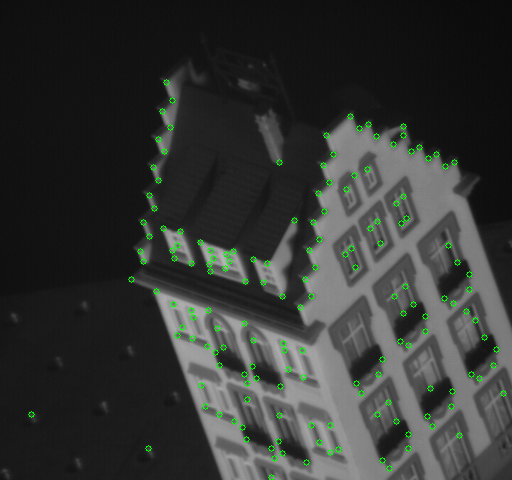

In [129]:
#  Visualizing keypoints
#  https://docs.opencv.org/4.x/d4/d8c/tutorial_py_shi_tomasi.html

DISPLAY_RADIUS = 3
DISPLAY_COLOR  = (0, 255, 0)

def keypointDetectionDemo(im0):
  # find image locations that may be good for tracking
  feature_params = dict( maxCorners = 300,
                       qualityLevel = 0.2, 
                       minDistance = 7,  
                       blockSize = 5 )     
  p0 = cv2.goodFeaturesToTrack(im0, mask = None, **feature_params)
  # now corners should contain an array of (floating point) pixel locations 
  if p0 is None:
    print("no keypoints were found!")
    return
  print (f'Number of detected keypoints = {p0.shape[0]}')

  # convert to kx2 format, where k is the number of feature points
  corners = np.zeros((p0.shape[0],2))
  for i in range(corners.shape[0]):
    corners[i] = p0[i][0]

  # draw a small circle at each detected point and display the result
  im0color = cv2.cvtColor(im0, cv2.COLOR_GRAY2BGR)
  cornersInt = np.intp(np.round(corners)) # convert to integers used for indexing 
  for i in cornersInt:
    x, y = i.ravel()      # returns a contiguous flattened array
    cv2.circle(im0color, (x, y), DISPLAY_RADIUS, DISPLAY_COLOR)

  cv2_imshow(im0color)
  return
  
# load and display a sample image, detect features, and display the results
im0 = cv2.imread("hotel_images/hotel.seq00.png", cv2.COLOR_BGR2GRAY)
keypointDetectionDemo(im0)

# Tracking

The goal is to track keypoints in hotel_images for images 1 to 50.

The KLT procedure operates on a pair of images that were captured at times t and t+1. For a given keypoint at (x, y) at time t, the procedure tries to find the new location (x', y') of the same keypoint at time t+1 (as shown in the image below)
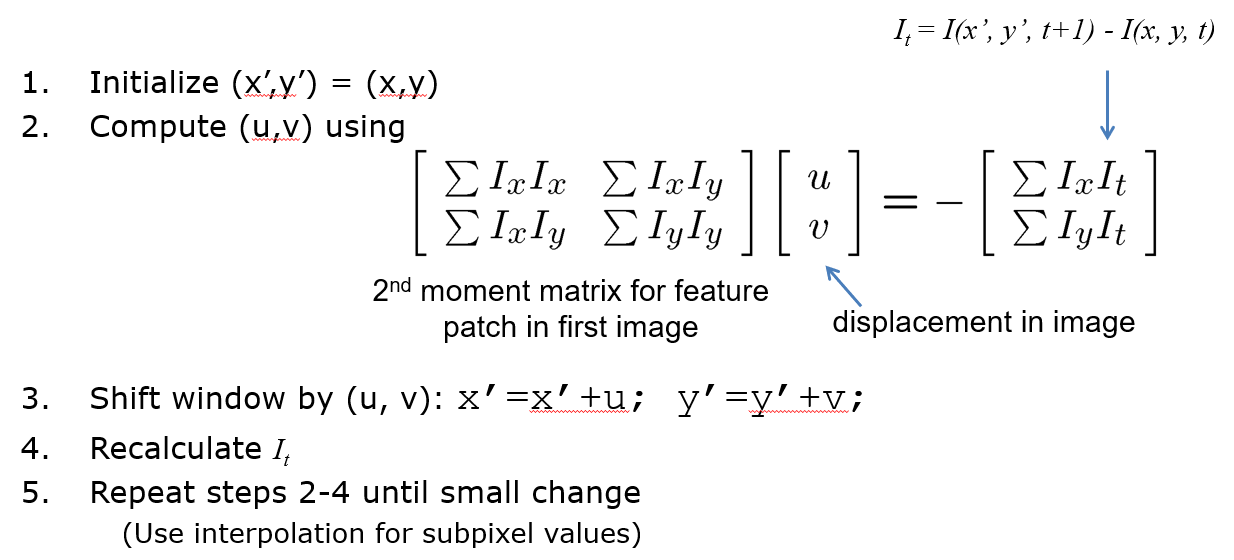


The KLT tracking procedure assumes small movements of keypoints from t to t+1. For this reason, tracking needs to be performed at subpixel resolution. Keypoint locations therefore need to be maintained using floating point values. 

The matrix equation depends on spatial gradients, which can be noisy. For this reason, smoothing of the spatial gradients is done when computing these matrices.

For each feature point in an image at time t, **`getNextPoints`** tries to find the location of the corresponding point in an image at time t+1.

In [130]:
# Function for convolution

def linear_filter(img, kernel):

  img_x, img_y = img.shape
  kernel_x, kernel_y = kernel.shape
  kernel_x = int(np.floor(kernel_x/2))
  kernel_y = int(np.floor(kernel_y/2))

  img_padded = np.pad(img, (kernel_x, kernel_y), 'constant', constant_values=0)
  X, Y = img_padded.shape

  conv_output = np.zeros((img_x, img_y))

  for i in range(kernel_x, X-kernel_x):
      for j in range(kernel_y, Y-kernel_y):
          window = img_padded[i-kernel_x:i+kernel_x+1, j-kernel_y:j+kernel_y+1]
          conv_output[i-kernel_x][j-kernel_y] = np.sum(window*kernel)

  return conv_output

In [131]:
def getNextPoints(im1, im2, xy, movedOutFlag):
  print("In function getNextPoints")

  xy2 = np.copy(xy).astype(float)
  im1 = im1.astype(np.float32)
  im2 = im2.astype(np.float32)

  # Gaussian kernel for smoothing
  kernel = np.array([
          [1, 4, 7, 4, 1],
          [4, 16, 26, 16, 4],
          [7, 26, 41, 26, 7],
          [4, 16, 26, 16, 4],
          [1, 4, 7, 4, 1,]], dtype=np.float32) / 273.0

  img = linear_filter(im1, kernel).astype(np.float32)
  Iy, Ix =  np.gradient(img)

  # The given KLT algorithm is implemented
  for i in range(len(xy)):
    patch_x = cv2.getRectSubPix(Ix, (15,15), (xy[i,0], xy[i,1]))
    patch_y = cv2.getRectSubPix(Iy, (15,15), (xy[i,0], xy[i,1]))
    A = np.array([[np.sum(patch_x * patch_x), np.sum(patch_x * patch_y)], [np.sum(patch_x * patch_y), np.sum(patch_y * patch_y)]])

    for j in range(25):
      patch_t = cv2.getRectSubPix(im2, (15,15), (xy2[i,0], xy2[i,1])) - cv2.getRectSubPix(img, (15, 15), (xy[i,0], xy[i,1]))
      B = -1* np.array([[np.sum(patch_x*patch_t)],[np.sum(patch_y*patch_t)]])
      disp = np.matmul(np.linalg.pinv(A), B)

      u = disp[0]
      v = disp[1]

      xy2[i] = [xy2[i,0] + u, xy2[i,1] + v] 

      # Checking if the norm of (u, v) is leser than the threshold (from the textbook section - 9.1.3 Incremental refinement)
      if np.hypot(u, v) <= 0.01:
        break

  # Setting the movedOutFlag to 1 if the new pixels are out of bounds      
  if xy2[i,0] >= len(im1) or xy2[i,0] < 0 or xy2[i,1] >= len(im1[0]) or xy2[i,1] < 0:
    movedOutFlag[i] = 1

  return(xy2, movedOutFlag)

In [132]:
## BUILT IN FUNCTION FOR TESTING


# def getNextPoints(im1, im2, xy, movedOutFlag):
#     '''Track keypoints from image im1 to image im2
#      Input:
#       im1: grayscale image at time t; shape (m, n)
#       im2: grayscale image at time t+1; shape (m, n)
#       xy:  a numpy array of size kx2, where k is the number of keypoints
#        Each keypoint is of the form [x, y], with both in floating-point format
#      Output:
#       xy2: updated keypoint locations; same format as xy input 
#       movedOutFlag: array of True/False values, of size kx1, 
#        to indicate whether each associated
#        keypoint has moved outside the dimensions of the image array

#     #  TO DO: Implement the getNextPoints function.
#   '''
#     #print("In function getNextPoints")
#     xy2 = np.copy(xy)

#     lk_params = dict( winSize = (15, 15),
#                   maxLevel = 0,
#                   criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT,
#                               1, 0.03))

#     p1, st, err = cv2.calcOpticalFlowPyrLK(im1,im2,np.float32(xy),None,**lk_params)

#     xy2 = p1

#     return ( xy2, movedOutFlag )

In [136]:
# Keypoint detector using Harris-corner criteria

def keypoint_detector(input_img, k, window_size, threshold):
    #print(input_img.shape)
    corners = []
    shift = int(window_size/2)
    y_range = input_img.shape[0] - shift
    x_range = input_img.shape[1] - shift

    kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    dx = linear_filter(input_img, kernel_x)
    dy = linear_filter(input_img, kernel_y)
    
    Ixx = dx**2
    Ixy = dy*dx
    Iyy = dy**2
    
    for y in range(shift, y_range):
        for x in range(shift, x_range):
            start_y = y - shift
            end_y = y + shift + 1
            start_x = x - shift
            end_x = x + shift + 1
            windowIxx = Ixx[start_y : end_y, start_x : end_x]
            windowIxy = Ixy[start_y : end_y, start_x : end_x]
            windowIyy = Iyy[start_y : end_y, start_x : end_x]
            Sxx = windowIxx.sum()
            Sxy = windowIxy.sum()
            Syy = windowIyy.sum()

            det = (Sxx * Syy) - (Sxy**2)
            trace = Sxx + Syy

            r = det - k*(trace**2)

            if r > threshold:
                corners.append([x, y])
    
    # NMS over a 5x5 neighborhood
    for i in range(len(corners)):
      for j in range(i+1,len(corners)):
        if((corners[i][0] +5) >= corners[j][0] and (corners[i][0] -5) < corners[j][0] and (corners[i][1] +5) >= corners[j][1] and (corners[i][1] -5) < corners[j][1]):
          corners[j][0] =0
          corners[j][1] =0      
    l = len(corners)
    i=0
    while(l):
      if(corners[i][0] == 0):
        corners.pop(i)        
      else:
        i=i+1
      l=l-1
    
    corners = np.asarray(corners)

    return corners

In [138]:
# KLT TRACKING - main code block

NUMBER_OF_IMAGES = 50  
DISPLAY_RADIUS = 3
GREEN = (0, 255, 0)
YELLOW = (0, 255, 255)

def mainFunction():
  print("In mainFunction")
  allImgs = readImages(NUMBER_OF_IMAGES)
  print (f'number of images that were read = {len(allImgs)}')

  # get initial keypoints from image 0
  image0 = allImgs[0]
  xy = getKeypoints(image0)
  if xy is None:
    print("no points to track!")
    return
  print (f'number of detected keypoints = {xy.shape[0]}')

  # display keypoints for image 0
  image0color = cv2.cvtColor(image0, cv2.COLOR_GRAY2BGR)
  corners = np.intp(np.round(xy))  
  for i in corners:
    x, y = i.ravel()
    cv2.circle(image0color, (x, y), DISPLAY_RADIUS, GREEN)

  # track the initial keypoints through all remaining images
  xyt = trackPoints(xy, allImgs)

  # in image 0, draw the paths taken by the keypoints 
  drawPaths(image0color, xyt)
  return


def readImages(filecount):
  print("In function readImages")
  allImages = []
  for i in range(filecount):
    print (f'reading image {i:02}')
    imagetmp = cv2.imread("hotel_images/hotel.seq" + f'{i:02d}' + ".png", cv2.COLOR_BGR2GRAY)
    allImages.append(imagetmp)
  return allImages


def getKeypoints(im0):
  corners = keypoint_detector(im0, 0.04, 5, 6000000000)

  # now corners should contain an array of (floating point) pixel locations 
  if corners is None:
    print("no keypoints were found!")
    return

  return corners
  

def trackPoints(xy, imageSequence):
  print ("In function trackPoints")
  print (f'length of imageSequence = {len(imageSequence)}')
  movedOutFlag = np.zeros(xy.shape[0])
  # initialize xyt to contain any information that is needed for drawing paths at the end of tracking
  # also add code in this function as needed to maintain xyt
  #xyt = 0

  # xyt is initialized as a list, to which the new points from getNextPoints can be added
  xyt = []

  for t in range(0, len(imageSequence)-1): # predict for all images except first in sequence
    print (f't = {t}; predicting for t = {t+1}') 
    xy2, movedOutFlag = getNextPoints(imageSequence[t], imageSequence[t+1], xy, movedOutFlag)
    xy = xy2

    for pt in xy2:
      xyt.append(pt)

    # for selected instants in time, display the latest image with highlighted keypoints 
    if ((t == 0) or (t == 10) or (t == 20) or (t == 30) or (t == 40) or (t == 49)):
      im2color = cv2.cvtColor(imageSequence[t+1], cv2.COLOR_GRAY2BGR)
      corners = np.intp(np.round(xy2))
        
      for c in range(0, corners.shape[0]):
        if movedOutFlag[c] == False:
          x = corners[c][0]
          y = corners[c][1]
          cv2.circle(im2color, (x, y), DISPLAY_RADIUS, GREEN)
      cv2_imshow(im2color)
    
  return xyt

def drawPaths(im0color, xyt):
  print ("In function drawPaths")

  # Using cv2.circle to draw dots for all new points in xyt, by setting radius to 0
  for pt in xyt:
    im0color = cv2.circle(im0color, (round(pt[0]),round(pt[1])), radius=0, color=YELLOW, thickness=1)

  print ("FINISHED: here are the paths of the tracked keypoints")
  cv2_imshow(im0color)

In mainFunction
In function readImages
reading image 00
reading image 01
reading image 02
reading image 03
reading image 04
reading image 05
reading image 06
reading image 07
reading image 08
reading image 09
reading image 10
reading image 11
reading image 12
reading image 13
reading image 14
reading image 15
reading image 16
reading image 17
reading image 18
reading image 19
reading image 20
reading image 21
reading image 22
reading image 23
reading image 24
reading image 25
reading image 26
reading image 27
reading image 28
reading image 29
reading image 30
reading image 31
reading image 32
reading image 33
reading image 34
reading image 35
reading image 36
reading image 37
reading image 38
reading image 39
reading image 40
reading image 41
reading image 42
reading image 43
reading image 44
reading image 45
reading image 46
reading image 47
reading image 48
reading image 49
number of images that were read = 50
number of detected keypoints = 308
In function trackPoints
length of image

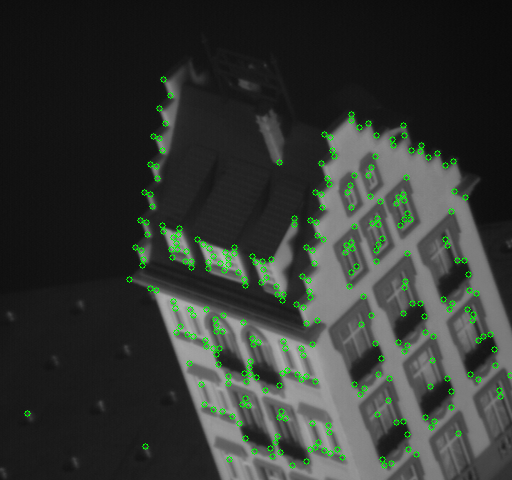

t = 1; predicting for t = 2
In function getNextPoints
t = 2; predicting for t = 3
In function getNextPoints
t = 3; predicting for t = 4
In function getNextPoints
t = 4; predicting for t = 5
In function getNextPoints
t = 5; predicting for t = 6
In function getNextPoints
t = 6; predicting for t = 7
In function getNextPoints
t = 7; predicting for t = 8
In function getNextPoints
t = 8; predicting for t = 9
In function getNextPoints
t = 9; predicting for t = 10
In function getNextPoints
t = 10; predicting for t = 11
In function getNextPoints


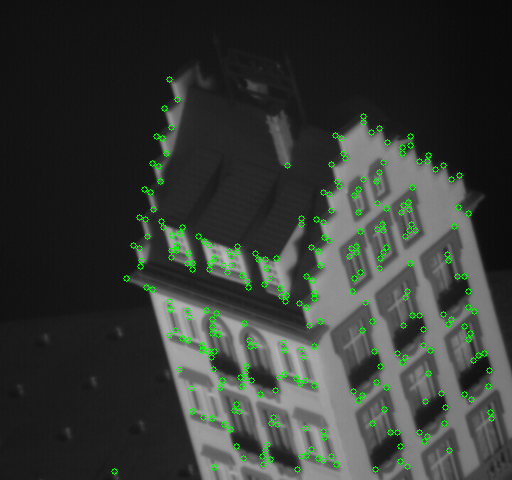

t = 11; predicting for t = 12
In function getNextPoints
t = 12; predicting for t = 13
In function getNextPoints
t = 13; predicting for t = 14
In function getNextPoints
t = 14; predicting for t = 15
In function getNextPoints
t = 15; predicting for t = 16
In function getNextPoints
t = 16; predicting for t = 17
In function getNextPoints
t = 17; predicting for t = 18
In function getNextPoints
t = 18; predicting for t = 19
In function getNextPoints
t = 19; predicting for t = 20
In function getNextPoints
t = 20; predicting for t = 21
In function getNextPoints


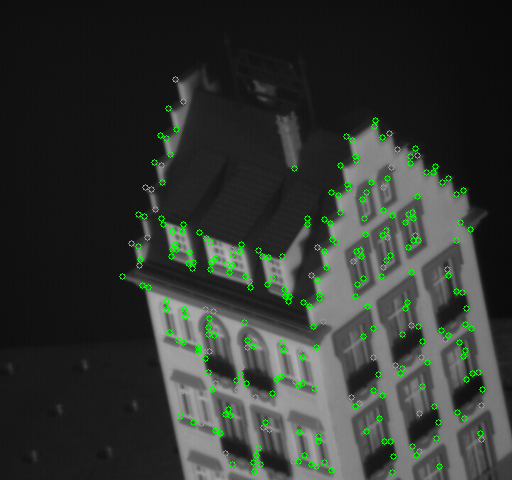

t = 21; predicting for t = 22
In function getNextPoints
t = 22; predicting for t = 23
In function getNextPoints
t = 23; predicting for t = 24
In function getNextPoints
t = 24; predicting for t = 25
In function getNextPoints
t = 25; predicting for t = 26
In function getNextPoints
t = 26; predicting for t = 27
In function getNextPoints
t = 27; predicting for t = 28
In function getNextPoints
t = 28; predicting for t = 29
In function getNextPoints
t = 29; predicting for t = 30
In function getNextPoints
t = 30; predicting for t = 31
In function getNextPoints


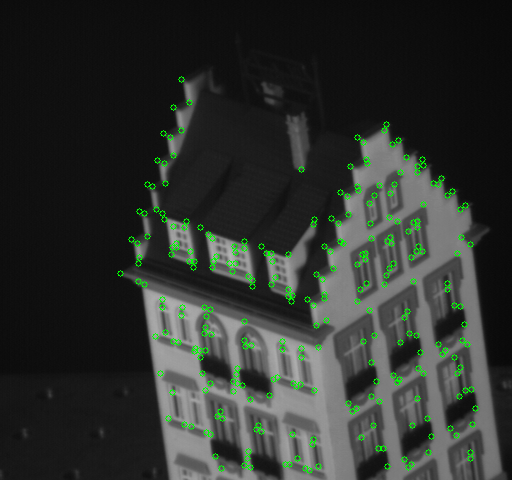

t = 31; predicting for t = 32
In function getNextPoints
t = 32; predicting for t = 33
In function getNextPoints
t = 33; predicting for t = 34
In function getNextPoints
t = 34; predicting for t = 35
In function getNextPoints
t = 35; predicting for t = 36
In function getNextPoints
t = 36; predicting for t = 37
In function getNextPoints
t = 37; predicting for t = 38
In function getNextPoints
t = 38; predicting for t = 39
In function getNextPoints
t = 39; predicting for t = 40
In function getNextPoints
t = 40; predicting for t = 41
In function getNextPoints


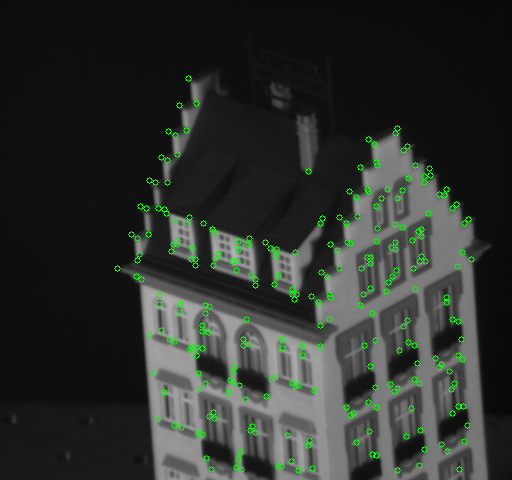

t = 41; predicting for t = 42
In function getNextPoints
t = 42; predicting for t = 43
In function getNextPoints
t = 43; predicting for t = 44
In function getNextPoints
t = 44; predicting for t = 45
In function getNextPoints
t = 45; predicting for t = 46
In function getNextPoints
t = 46; predicting for t = 47
In function getNextPoints
t = 47; predicting for t = 48
In function getNextPoints
t = 48; predicting for t = 49
In function getNextPoints
In function drawPaths
FINISHED: here are the paths of the tracked keypoints


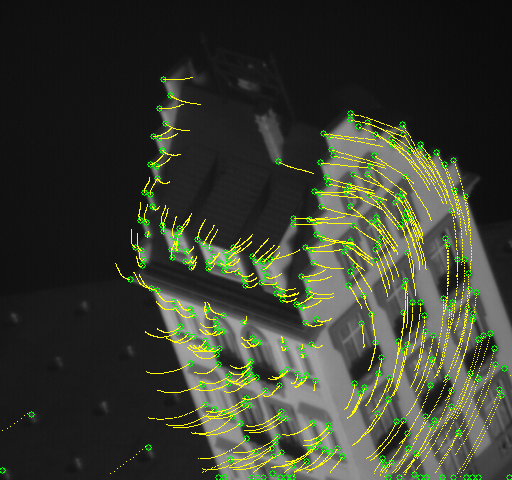

In [139]:
# Testing the KLT tracking code
mainFunction()